In [52]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
from copy import copy
from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_ips, calc_mips
from utils import eps_greedy_policy, aggregate_simulation_results, remove_outliers

In [53]:
from sklearn.utils import check_random_state
from scipy.stats import rankdata
import numpy as np
from utils import sample_action_fast, sigmoid, softmax, eps_greedy_policy

In [54]:
def generate_waseda_student_data3(
    num_data: int,
    phi_a: np.ndarray,
    theta_g_0: np.ndarray,#以下q0の値
    M_g_0: np.ndarray,
    b_g_0: np.ndarray,
    theta_h_0: np.ndarray,
    M_h_0: np.ndarray,
    b_h_0: np.ndarray,
    theta_g_1: np.ndarray,  # 以下 q1 の値
    M_g_1: np.ndarray,
    b_g_1: np.ndarray,
    theta_h_1: np.ndarray,
    M_h_1: np.ndarray,
    b_h_1: np.ndarray,
    lambda1_: float ,
    lambda0_: float ,
    dim_context: int ,
    num_actions: int ,
    num_clusters: int ,
    beta: float ,
    num_def_actions: int = 0 ,
    random_state: int = 12345,
) -> dict:
    """行動特徴量を活用したオフ方策評価におけるログデータを生成する."""
    random_ = check_random_state(random_state)
    x = random_.normal(size=(num_data, dim_context))
    one_hot_a, one_hot_c = np.eye(num_actions), np.eye(num_clusters)
    
    # 期待報酬関数1を定義する
    g_x_c_1 = (
            (x - x ** 2) @ theta_g_1 + (x ** 3 + x ** 2 - x) @ M_g_1 @ one_hot_c + b_g_1
        ) / 10
    h_x_a_1 = (
            (x ** 3 + x ** 2 - x) @ theta_h_1 + (x - x ** 2) @ M_h_1 @ one_hot_a + b_h_1
        ) / 10
    q_x_a_1 = (1 - lambda1_) * g_x_c_1[:, phi_a] + lambda1_ * h_x_a_1

    #期待報酬関数０を定義する
    g_x_c_0 = (
            (x - x ** 2) @ theta_g_0 + (x ** 3 + x ** 2 - x) @ M_g_0 @ one_hot_c + b_g_0
        ) / 10
    h_x_a_0 = (
            (x ** 3 + x ** 2 - x) @ theta_h_0 + (x - x ** 2) @ M_h_0 @ one_hot_a + b_h_0
        ) / 10
    q_x_a_0 = (1 - lambda0_) * g_x_c_0[:, phi_a] + lambda0_ * h_x_a_0

    #期待報酬関数の差をCATEとして定義
    cate_x_a = q_x_a_1 - q_x_a_0

    #データ収集方策を定義する
    pi_0 = softmax(beta*cate_x_a)
    pi_0[:, :num_def_actions] = 0
    pi_0 = pi_0 / pi_0.sum(1)[:, np.newaxis]

    # 行動や報酬を抽出する
    a = sample_action_fast(pi_0, random_state=random_state)
    a_mat = np.zeros((num_data, num_actions), dtype=int)
    a_mat[np.arange(num_data), a] = 1
    pscore_mat = a_mat * pi_0 + (1 - a_mat) * (1 - pi_0)

    q_x_a_factual = a_mat * q_x_a_1 + (1 - a_mat) * q_x_a_0
    r_mat = random_.normal(q_x_a_factual)
    
    c = phi_a[a]
    c_mat = np.zeros((num_data,num_clusters))
    for i in range(num_data):
        c_mat[i,c[i]] = 1
    

    return dict(
        num_data=num_data, # データの数
        num_actions=num_actions, #アクション数
        num_clusters = num_clusters,
        x=x,  #特徴量
        a=a,   #行動
        c = c, 
        c_mat = c_mat,     
        r=r_mat[np.arange(num_data), a],
        a_mat=a_mat,
        r_mat=r_mat,
        phi_a = phi_a,
        pi_0=pi_0,
        pscore=pi_0[np.arange(num_data), a],
        pscore_mat=pscore_mat,
        g_x_c_1=(1 - lambda1_) * g_x_c_1,
        h_x_a_1=lambda1_ * h_x_a_1,
        g_x_c_0=(1 - lambda0_) * g_x_c_0,
        h_x_a_0=lambda0_ * h_x_a_0,
        q_x_a_1=q_x_a_1,
        q_x_a_0=q_x_a_0,
        cate_x_a=cate_x_a,
    )
    

In [55]:
def calc_true_value2(
    dim_context: int,
    num_actions: int,
    num_clusters: int,
    phi_a: np.ndarray,
    theta_g_0,
    M_g_0,
    b_g_0,
    theta_h_0,
    M_h_0,
    b_h_0,
    theta_g_1,
    M_g_1,
    b_g_1,
    theta_h_1,
    M_h_1,
    b_h_1,
    lambda0_,
    lambda1_,
    beta
):
    """評価方策の真の性能を近似する."""
    test_bandit_data = generate_waseda_student_data3(
        num_data=10000,
        dim_context=dim_context,
        num_actions=num_actions,
        num_clusters=num_clusters,
        phi_a=phi_a,
        theta_g_0=theta_g_0,
        M_g_0=M_g_0,
        b_g_0=b_g_0,
        theta_h_0=theta_h_0,
        M_h_0=M_h_0,
        b_h_0=b_h_0,
        theta_g_1=theta_g_1,
        M_g_1=M_g_1,
        b_g_1=b_g_1,
        theta_h_1=theta_h_1,
        M_h_1=M_h_1,
        b_h_1=b_h_1,
        lambda0_=lambda0_,
        lambda1_=lambda1_,
        beta=beta,
    )

    cate_x_a = test_bandit_data["cate_x_a"]
    pi =eps_greedy_policy(cate_x_a)
    
    q_x_a_1 =test_bandit_data["q_x_a_1"]
    q_x_a_0 = test_bandit_data["q_x_a_0"]

    return (pi*q_x_a_1+(1-pi)*q_x_a_0).sum(1).mean()


In [56]:
def calc_new_mips_takashi(
    dataset:dict, 
    pi:np.ndarray,
    replace_c:int = 0,
    is_estimate_w: bool = False
    ) ->float:
    
    num_data = dataset["num_data"]
    num_actions, num_clusters = dataset["num_actions"], dataset["num_clusters"]
    x, a, c, r = dataset["x"], dataset["a"], copy(dataset["c"]),dataset["r"]
    pi_0, phi_a = dataset["pi_0"], copy(dataset["phi_a"])
    min_value, max_value = r.min(), r.max()
    #actionしない行動確率を定義
    a_mat, r_mat = dataset["a_mat"], copy(dataset["r_mat"])
    c_mat = dataset["c_mat"]
    not_c_mat = 1 - c_mat

 
    if replace_c > 0:
        #replace_c個のクラスタをnum_clusters - replace_c - 1に結合
        c[c >= num_clusters - replace_c] = num_clusters - replace_c - 1
        phi_a[phi_a >= num_clusters - replace_c] = num_clusters - replace_c - 1


    if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        return np.clip((w_x_c_hat * r).mean(), min_value, max_value)

    else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat[:,phi_a == c_].sum(1)
            
        # (1) π(e_i|x_i) / π_0(e_i|x_i) * r_i(e_i, 0)
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        #term1 = w_x_c_1 * r  # 第一項

        # (2) Σ_(e ∈ E/{e_i}) ((1 - π(e|x)) / (1 - π_0(e|x)) * r_i(e, 0))
        # 非選択アクションの重みと報酬を計算
        #denom = 1 - (pi_0_c * not_c_mat)  # 1 - π_0(e|x)
        #denom[denom == 0] = 1  # ゼロ割りを防止
        #w_x_c_0 = (not_c_mat - (pi_c * not_c_mat)) / denom  # 重み
        #w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)     # NaN を 0 に置換
        #term2 = (w_x_c_0 * r_c_mat).sum(axis=1)     # 第二項
        
        w_x_c_0 = (num_actions*not_c_mat - (pi_c* not_c_mat))/ (not_c_mat -(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1.shape)
        #print(w_x_c_0.shape)
        #print(w_x_c_0[0])
        
        
        #print((w_x_c_1 * r).shape)
        #print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        
        # 全体の報酬
        #total_reward = term1 + term2
        #return total_reward.mean()
        #print("w_x_c_0*r_c_mat:" ,(w_x_c_0*r_c_mat).shape)
        return np.clip((w_x_c_1 * r + (w_x_c_0*r_c_mat).sum(1)).mean(), min_value, max_value)
    
    

In [57]:
## IPSを定義

def calc_new_ips(dataset:dict, pi:np.ndarray) ->float:
    """
    IPS推定量

    Args:
        dataset (dict): _description_
        pi (np.ndarray): _description_

    Returns:
        float: _description_
    """
    
    pi_0 = dataset["pi_0"]
    
    ones = np.ones((dataset["num_data"],dataset["num_actions"]))
    a = dataset["a_mat"]
    not_a = ones-dataset["a_mat"]
    
    
    #r_a_1にかかるウエイトと，r_a_0にかかるウエイトを作成
    w_1 = pi*a / pi_0*a  # n×|A|
    w_0 = ((ones*not_a)-(pi*not_a)) / ((ones*not_a)-(pi_0*not_a)) # n×|A|
    
    w_1 = np.nan_to_num(w_1,nan=0)
    w_0 = np.nan_to_num(w_0, nan=0)
    
    return (dataset["r_mat"]*w_1 + dataset["r_mat"]*w_0).sum(1).mean()

In [58]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_clusters = 30 # 行動クラスタ数
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda1_ = 0.0 # クラスタ効果と残差効果の配合率
lambda0_ = 0.0
random_state = 12345
random1_ = check_random_state(random_state)
random0_ = check_random_state(random_state+22)
random_ = check_random_state(random_state+1)
num_actions_list = [250, 500] # 行動数, |A|

In [ ]:

y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}



In [60]:
result_df_list = []
theta_g_1 = random1_.normal(size=(dim_context, num_clusters))
M_g_1 = random1_.normal(size=(dim_context, num_clusters))
b_g_1 = random1_.normal(size=(1, num_clusters))
theta_g_0 = random0_.normal(size=(dim_context, num_clusters))
M_g_0 = random0_.normal(size=(dim_context, num_clusters))
b_g_0 = random0_.normal(size=(1, num_clusters))

for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    phi_a = random_.choice(num_clusters, size=num_actions)
    
    theta_h_1 = random1_.normal(size=(dim_context, num_actions))
    M_h_1 = random1_.normal(size=(dim_context, num_actions))
    b_h_1 = random1_.normal(size=(1, num_actions))

    theta_h_0 = random0_.normal(size=(dim_context, num_actions))
    M_h_0 = random0_.normal(size=(dim_context, num_actions))
    b_h_0 = random0_.normal(size=(1, num_actions))
    

    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value2(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, phi_a=phi_a,
        theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
        M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
        b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
        b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,beta=beta
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_waseda_student_data3(
            num_data=num_data, phi_a=phi_a,
            theta_g_0=theta_g_0,M_g_0=M_g_0,b_g_0=b_g_0,theta_h_0=theta_h_0,
            M_h_0=M_h_0,b_h_0=b_h_0,theta_g_1=theta_g_1,M_g_1=M_g_1,
            b_g_1=b_g_1,theta_h_1=theta_h_1,M_h_1=M_h_1,
            b_h_1=b_h_1,lambda0_=lambda0_,lambda1_=lambda1_,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,beta=beta, random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["ips"] = calc_new_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_new_mips_takashi(offline_logged_data, pi)
        #estimated_policy_values["mips (w_hat)"] = calc_mips(offline_logged_data, pi, is_estimate_w=True)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=500...: 100%|██████████| 50/50 [00:06<00:00,  7.82it/s]


In [62]:
print(offline_logged_data["g_x_c_0"][0][0])
print(offline_logged_data["g_x_c_1"][0][0])
print(offline_logged_data["q_x_a_0"][0][0])
print(offline_logged_data["q_x_a_1"][0][0])
print(offline_logged_data["cate_x_a"][0][0])
print(offline_logged_data["r_mat"])


-0.722051933827585
-0.021608201118991265
1.0192288747917448
-0.6486485990550953
-1.6678774738468403
[[ 2.99893261 -1.21675642  2.9161173  ... -2.5313997   3.70971574
   0.14091388]
 [ 0.74521285 -0.01220589  0.90923196 ...  0.91176283 -0.37667135
   0.2113071 ]
 [ 1.45564322  0.08876621 -0.47907596 ... -0.20838529  1.41661947
   0.16583992]
 ...
 [-0.14021094 -0.85845771 -1.2875268  ... -0.19265573  2.41780792
   0.38135956]
 [-0.04697919  0.21478376  0.23025542 ...  0.17625397  0.33178253
  -0.80766995]
 [ 1.23812679 -0.61815047  1.33054478 ... -1.60695079  0.42288205
  -1.04688774]]


In [63]:
mips = calc_new_mips_takashi(offline_logged_data, pi)
print(mips)

-11.179415266012665


In [64]:
result_df_actions

,index,est,value,num_actions,se,bias,variance,true_value
0,0,ips,-16.177572,250,12.661051,0.046207,11.177511,-19.735809
1,0,mips,-4.843873,250,221.769785,111.104243,18.934135,-19.735809
2,1,ips,-16.899115,250,8.046838,0.046207,6.873502,-19.735809
3,1,mips,-12.200534,250,56.780369,111.104243,9.031977,-19.735809
4,2,ips,-20.096295,250,0.129950,0.046207,0.331136,-19.735809
...,...,...,...,...,...,...,...,...
195,47,mips,-10.875595,500,388.323817,454.663248,2.614367,-30.581528
196,48,ips,-37.606114,500,49.344805,0.247968,56.588748,-30.581528
197,48,mips,-8.377969,500,492.998030,454.663248,0.775677,-30.581528
198,49,ips,-39.700469,500,83.155068,0.247968,92.484836,-30.581528


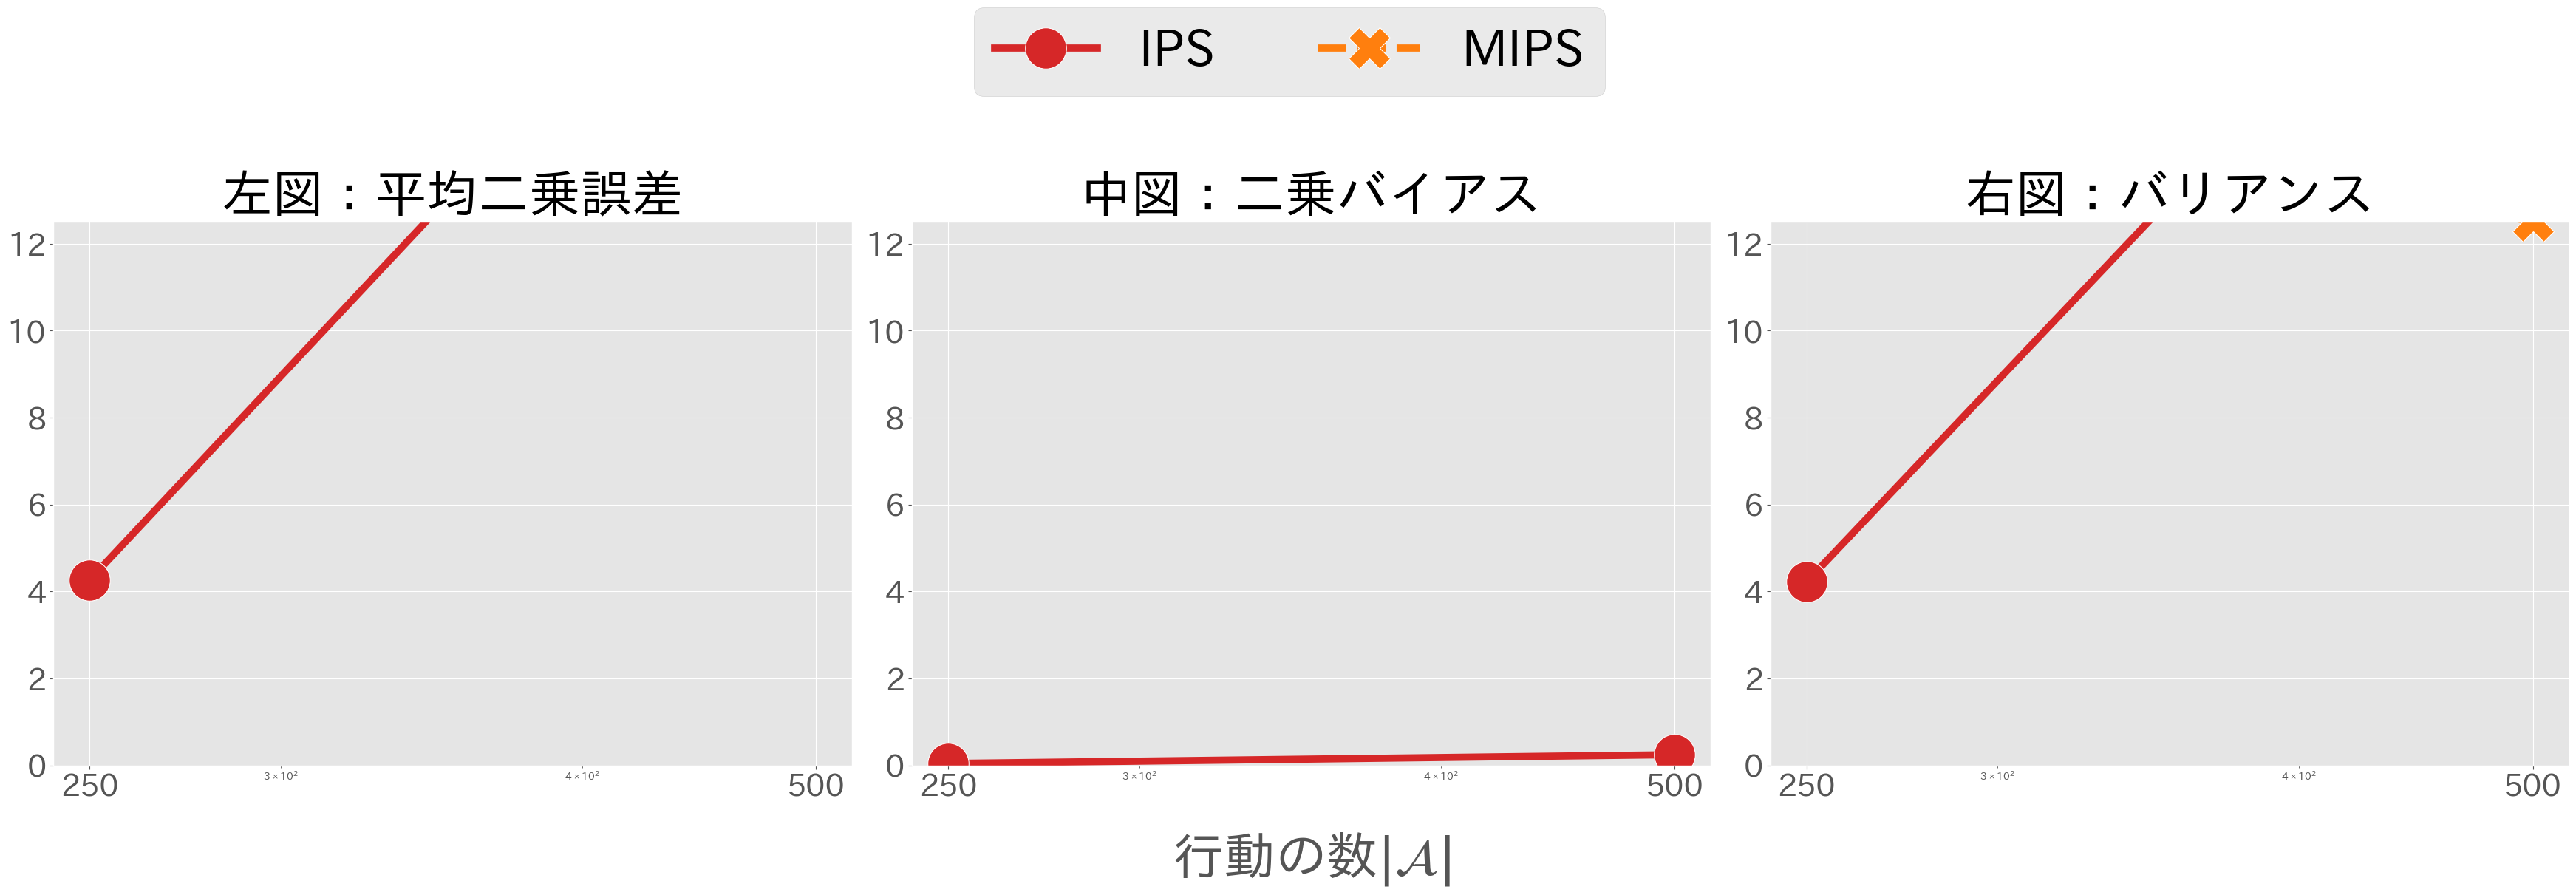

In [65]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange"],
        data=result_df_actions.query("est == 'ips' or est == 'mips'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 12.5)
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

In [66]:
num_data = offline_logged_data["num_data"]
num_actions, num_clusters = offline_logged_data["num_actions"], offline_logged_data["num_clusters"]
x, a, c, r = offline_logged_data["x"], offline_logged_data["a"], copy(offline_logged_data["c"]),offline_logged_data["r"]
pi_0, phi_a = offline_logged_data["pi_0"], copy(offline_logged_data["phi_a"])
min_value, max_value = r.min(), r.max()
#actionしない行動確率を定義
a_mat, r_mat = offline_logged_data["a_mat"], copy(offline_logged_data["r_mat"])
not_a_mat = 1 - a_mat
c_mat = offline_logged_data["c_mat"]
not_c_mat = 1 - c_mat

In [67]:
is_estimate_w=False
replace_c = 0
if is_estimate_w:#p(a|e,x)の推定
        x_c = np.c_[x, np.eye(num_clusters)[c]]
        print(x.shape)
        print(x_c.shape)
        pi_a_x_c_model = LogisticRegression(C=5, random_state=12345)
        pi_a_x_c_model.fit(x_c, a)

        w_x_a_full = pi / pi_0
        pi_a_x_c_hat = np.zeros((num_data, num_actions))
        pi_a_x_c_hat[:, np.unique(a)] = pi_a_x_c_model.predict_proba(x_c)
        print(pi_a_x_c_hat.shape)
        w_x_c_hat = (pi_a_x_c_hat * w_x_a_full).sum(1)

        print(np.clip((w_x_c_hat * r).mean(), min_value, max_value))

else:#p(e|a,x)=1としている
        pi_0_c = np.zeros((num_data, num_clusters - replace_c))
        pi_c = np.zeros((num_data, num_clusters - replace_c))
        
        r_c_mat = np.zeros((num_data, num_clusters - replace_c))
        r_mat_not_a = r_mat * (1-a_mat)
        for c_ in range(num_clusters - replace_c):
            pi_0_c[:, c_] = pi_0[:, phi_a == c_].sum(1)
            pi_c[:, c_] = pi[:, phi_a == c_].sum(1)
            
            r_c_mat[:,c_] = r_mat_not_a[:,phi_a == c_].sum(1)
            
    
            
        
        not_r_c_mat = r_c_mat * not_c_mat
        # 周辺重要度重み
        w_x_c_1 = pi_c[np.arange(num_data), c] / pi_0_c[np.arange(num_data), c]
        w_x_c_0 = (not_c_mat - (pi_c*not_c_mat))/ (not_c_mat-(pi_0_c*not_c_mat))
        #nanを０に変更
        w_x_c_0 = np.nan_to_num(w_x_c_0, nan=0)
        #print(w_x_c_1)
        print(w_x_c_0)
        #print(w_x_c_0[0])
        print(not_r_c_mat.shape)
        
        print((w_x_c_1 * r).shape)
        print(((w_x_c_0*not_r_c_mat).sum(1)).shape)
        print(np.clip((w_x_c_1 * r + ((w_x_c_0*not_r_c_mat).sum(1))).mean(), min_value, max_value))  
    
    
    


[[1.02481689 1.03268393 1.02351401 ... 1.03467586 1.03715441 1.03517977]
 [0.09869397 1.03210225 1.0478567  ... 1.037633   1.02433368 1.0286901 ]
 [1.02797553 1.02548214 1.03477589 ... 1.04377832 1.02738649 0.        ]
 ...
 [1.02697993 1.02877813 1.03297259 ... 1.04727764 1.02318458 1.04187825]
 [1.03701778 0.         1.03042723 ... 1.04985986 1.02752297 1.03553219]
 [0.09912528 1.02765711 1.03218217 ... 1.03850274 1.03527486 1.0267517 ]]
(500, 30)
(500,)
(500,)
-11.179415266012665
